# Exercício 1 - Especialização en Ciências de Dados

## Import de Pacotes

In [10]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

## Leitura dos Dados do Problema

In [11]:
df = pd.read_excel("funcao.xlsx")
# Remover linhas que tenham pelo menos 1 NaN
df = df.dropna()

In [12]:
print(df.shape)
df.head()

(200, 4)


,x,y,xgrd,ymean
0,3.7940,0.7464,-8.0,2.3077
1,10.9934,2.0146,-7.9,2.3107
2,7.6688,1.6048,-7.8,2.3137
3,-2.9656,2.7960,-7.7,2.3168
4,7.6470,1.3997,-7.6,2.3199


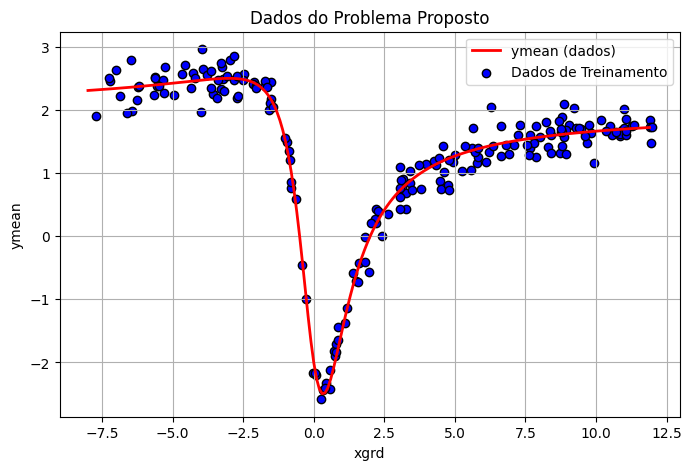

In [13]:
plt.figure(figsize=(8,5))
# plot predição contínua em linha
# ordenar por x para linha ficar correta
xgrd = df.xgrd.to_numpy()
ymean = df.ymean.to_numpy()
idx = np.argsort(xgrd.reshape(-1))
plt.plot(xgrd.reshape(-1)[idx], ymean[idx], linewidth=2, color="red", label="ymean (dados)")
plt.scatter(df.x, df.y, color='blue', label='Dados de Treinamento', edgecolor='black',)
plt.xlabel("xgrd")
plt.ylabel("ymean")
plt.legend()
plt.title("Dados do Problema Proposto")
plt.grid(True)
plt.show()

## Função Genérica para Criação das Redes Neurais

In [28]:
def build_mlp(input_dim, hidden_units, lr=1e-2, activation_function='tanh'):
    # hidden_units: tuple/list com números de neurônios por camada oculta, ex (8,), (16,8)
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    for units in hidden_units:
        model.add(Dense(units, activation=activation_function))
    model.add(Dense(1, activation="linear"))  # regressão
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=["mse"])
    return model

## Teste de Diferentes Arquiteturas

In [15]:
def search_minimal_topology(df,
                            neurons_list=[2,4,8,16,32],
                            max_hidden_layers=2,
                            epochs=100,
                            lr=1e-2,
                            verbose=0):

    x = df.x.to_numpy()
    y = df.y.to_numpy()

    x_val = df.xgrd.to_numpy()
    y_val = df.ymean.to_numpy()
    
    # gera combinações de topologias
    archs = []
    for n_layers in range(1, max_hidden_layers+1):
        for combo in itertools.product(neurons_list, repeat=n_layers):
            archs.append(tuple(combo))
    
    results = []
    best_val_mse = float("inf")
    best_result = None
    selected_model = None

    for i, arch in enumerate(archs):
        model = build_mlp(1, arch, lr=lr)
        hist = model.fit(x, y, validation_data=(x_val, y_val), epochs=epochs, verbose=verbose)
        val_mse = float(min(hist.history["val_loss"]))  # best val loss restored

        results.append({
            "arch": arch,
            "val_mse": val_mse,
            "history": hist.history,
            "trained_model": model
        })
        
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_result = results[-1]
            selected_model = i

    # cria tabela somente com arquitetura e mse
    df_results = pd.DataFrame([
        {"Architecture": r["arch"], "Validation MSE": r["val_mse"]}
        for r in results
    ])
    print("\nResultados por arquitetura:\n")
    print(df_results.to_string(index=False))

    return results, selected_model, (x_val, y_val)

## Plote de Resultados do Melhor Modelo

In [16]:
def plot_training_history(history):
    plt.figure(figsize=(8,6))
    # MSE
    if "mse" in history:
        plt.plot(history["mse"], label="MSE (Treino)")
    if "val_mse" in history:
        plt.plot(history["val_mse"], label="MSE (Validação)")
    
    plt.xlabel("Época")
    plt.ylabel("Valor")
    plt.title("Evolução do Treinamento")
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def plot_results(model, x_train, y_train, x, y):
    # predição sobre todo domínio X para traçar curva
    ypred = model.predict(x)

    plt.figure(figsize=(8,5))
    # plot predição contínua em linha
    # ordenar por x para linha ficar correta
    idx = np.argsort(x.reshape(-1))
    plt.plot(x.reshape(-1)[idx], y[idx], linewidth=2, color="red", label="ymean (dados)")
    plt.plot(x.reshape(-1)[idx], ypred[idx], linewidth=2, label="MLP predição", color="blue")
    plt.scatter(x_train, y_train, color='yellow', edgecolor='black', label='Dados de Treinamento')
    plt.xlabel("xgrd")
    plt.ylabel("ymean")
    plt.legend()
    plt.title("Comparação: ymean vs predição MLP")
    plt.grid(True)
    plt.show()


Resultados por arquitetura:

Architecture  Validation MSE
        (4,)        0.012011
        (8,)        0.016472
       (16,)        0.003282
       (32,)        0.002333
      (4, 4)        0.003550
      (4, 8)        0.002403
     (4, 16)        0.003908
     (4, 32)        0.002480
      (8, 4)        0.002334
      (8, 8)        0.002381
     (8, 16)        0.002077
     (8, 32)        0.002043
     (16, 4)        0.002425
     (16, 8)        0.002843
    (16, 16)        0.002113
    (16, 32)        0.003032
     (32, 4)        0.002495
     (32, 8)        0.002622
    (32, 16)        0.001997
    (32, 32)        0.001688
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


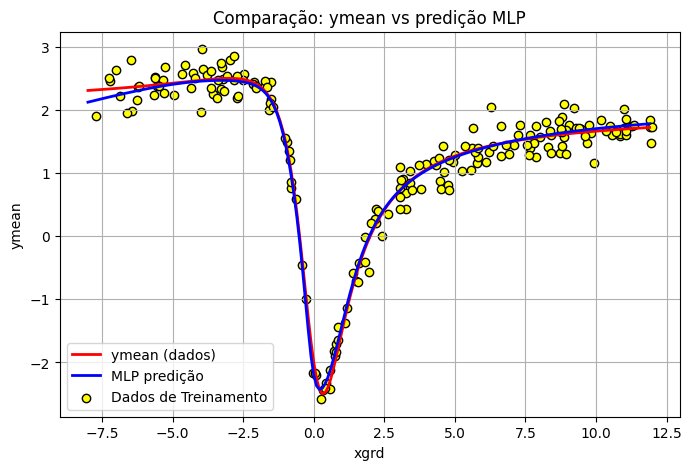

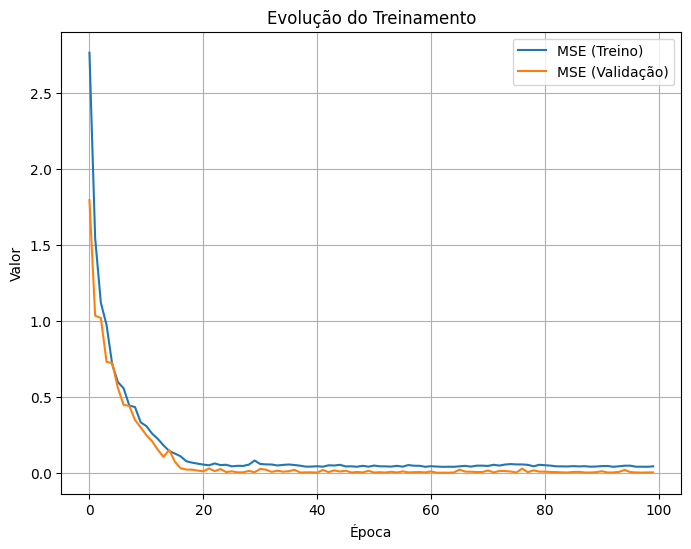

In [18]:
# --- uso principal ---
results, model_sel, test_pack = search_minimal_topology(
    df,
    neurons_list=[4,8,16,32],
    max_hidden_layers=2,
    epochs=100,
    lr=0.01,
    verbose=0
)
x_val, y_val = test_pack
x=df.x.to_numpy()
y=df.y.to_numpy()
plot_results(results[model_sel]["trained_model"], x, y, x_val, y_val)
plot_training_history(results[model_sel]["history"])

## Descrição da Rede Selecionada


--- Resumo da rede selecionada ---


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,461 (13.52 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,308 (9.02 KB)

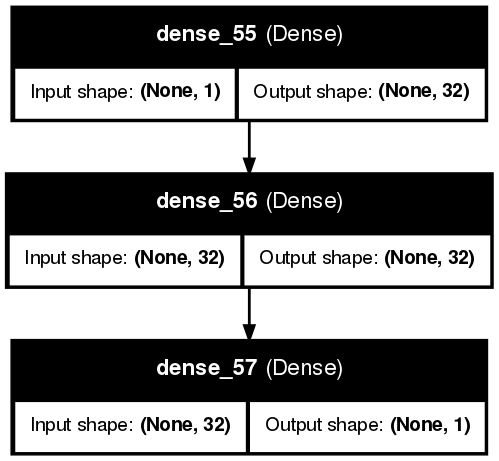

In [19]:
print("\n--- Resumo da rede selecionada ---")
results[model_sel]["trained_model"].summary()

# salvar visualização da arquitetura
from tensorflow.keras.utils import plot_model
plot_model(results[model_sel]["trained_model"], show_shapes=True, show_layer_names=True, dpi=100)

In [20]:
def plot_mlp_architecture(model, neuron_horizontal_spacing=2, neuron_size=0.2, bias_size=0.15, bias_offset=1):
    input_dim = model.input_shape[-1]
    layers = [layer.units for layer in model.layers if hasattr(layer, "units")]
    layers = [input_dim] + layers

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.axis("off")

    coords = []

    for i, n_neurons in enumerate(layers):
        x = i * neuron_horizontal_spacing

        # centralização vertical dos neurônios
        if n_neurons % 2 == 0:
            y_positions = np.linspace(-n_neurons/2 + 0.5, n_neurons/2 - 0.5, n_neurons)
        else:
            y_positions = np.linspace(-(n_neurons-1)/2, (n_neurons-1)/2, n_neurons)

        if i == len(layers)-1 and n_neurons == 1:
            y_positions = [0]

        layer_coords = []
        for y in y_positions:
            if i == 0:  # entradas
                rect = plt.Rectangle((x - neuron_size, y - neuron_size),
                                     2*neuron_size, 2*neuron_size,
                                     color="lightgreen", ec="black", zorder=3)
                ax.add_patch(rect)
            elif i == len(layers)-1:  # saída
                circle = plt.Circle((x, y), neuron_size, color="salmon", ec="black", zorder=3, alpha=0.9)
                ax.add_patch(circle)
            else:  # camadas ocultas
                circle = plt.Circle((x, y), neuron_size, color="skyblue", ec="black", zorder=3, alpha=0.9)
                ax.add_patch(circle)

            layer_coords.append((x, y))

        coords.append(layer_coords)

        # plotar bias antes da camada (exceto entrada)
        if i > 0:
            bias_x = x - bias_offset  # antes da camada
            bias_y = max(y_positions) + 2*bias_size + 2*neuron_size  # acima do maais alto neurônio
            bias_circle = plt.Circle((bias_x, bias_y), bias_size, color="orange", ec="black", zorder=4, alpha=0.4)
            ax.add_patch(bias_circle)
            # conectar bias a todos os neurônios da camada
            for y_neuron in y_positions:
                ax.plot([bias_x, x], [bias_y, y_neuron], "k--", lw=0.5, zorder=2)

        # conexões para próxima camada
        if i < len(layers)-1:
            next_n = layers[i+1]
            if i+1 == len(layers)-1 and next_n == 1:
                next_y_positions = [0]
            else:
                if next_n % 2 == 0:
                    next_y_positions = np.linspace(-next_n/2 + 0.5, next_n/2 - 0.5, next_n)
                else:
                    next_y_positions = np.linspace(-(next_n-1)/2, (next_n-1)/2, next_n)

            for (x1, y1) in layer_coords:
                for y2 in next_y_positions:
                    ax.plot([x1, x1+neuron_horizontal_spacing], [y1, y2], "k-", lw=0.5, zorder=1)

    plt.title("Arquitetura MLP com Bias Antes da Camada", fontsize=14)
    plt.show()


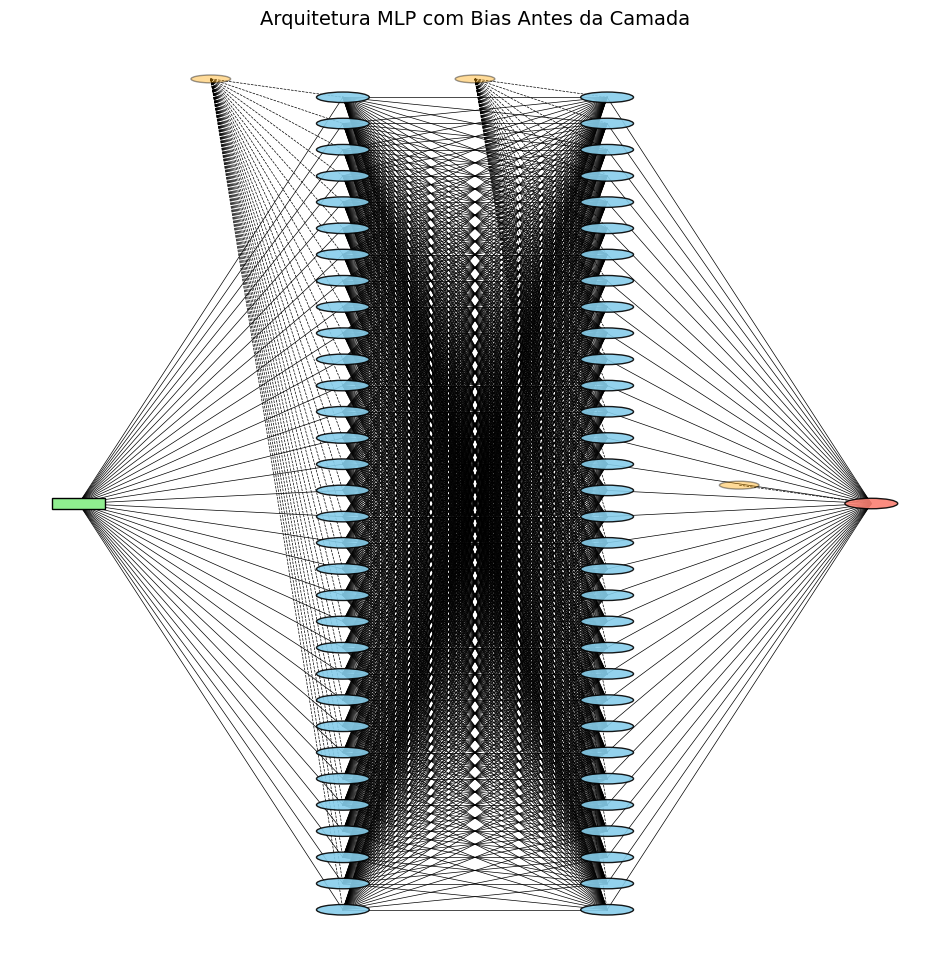

In [21]:
plot_mlp_architecture(results[model_sel]["trained_model"])

## Variação da Função de Ativação para a Melhor Arquitetura Encontrada (considerando como métrica o MSE)

In [29]:
results = []

# Teste diferentes funções de ativação para a camada escondida
for act_function in ["relu", "tanh", "sigmoid"]:
    for run in range(5):  # roda 5 vezes
        model = build_mlp(1, (32, 32), lr=0.01, activation_function=act_function)
        hist = model.fit(x, y, validation_data=(x_val, y_val), epochs=100, verbose=0)
        val_mse = float(min(hist.history["val_loss"]))  # best val loss restored

        results.append({
            "activation_function": act_function,
            "run": run + 1,
            "val_mse": val_mse,
            "history": hist.history,
            "trained_model": model
        })

# tabela detalhada com todas as execuções
df_results = pd.DataFrame([
    {"Activation": r["activation_function"], "Run": r["run"], "Validation MSE": r["val_mse"]}
    for r in results
])

print("\nResultados por função de ativação (5 execuções cada):\n")
print(df_results.to_string(index=False))

# tabela resumo com média e desvio padrão
df_summary = df_results.groupby("Activation")["Validation MSE"].agg(["mean", "std"]).reset_index()
df_summary.rename(columns={"mean": "Mean MSE", "std": "Std MSE"}, inplace=True)

print("\nResumo (média e desvio padrão do MSE por ativação):\n")
print(df_summary.to_string(index=False))



Resultados por função de ativação (5 execuções cada):

Activation  Run  Validation MSE
      relu    1        0.004480
      relu    2        0.002451
      relu    3        0.003069
      relu    4        0.004335
      relu    5        0.004057
      tanh    1        0.001861
      tanh    2        0.001323
      tanh    3        0.002714
      tanh    4        0.001722
      tanh    5        0.001706
   sigmoid    1        0.003726
   sigmoid    2        0.002372
   sigmoid    3        0.002481
   sigmoid    4        0.001941
   sigmoid    5        0.002290

Resumo (média e desvio padrão do MSE por ativação):

Activation  Mean MSE  Std MSE
      relu  0.003679 0.000879
   sigmoid  0.002562 0.000681
      tanh  0.001865 0.000515


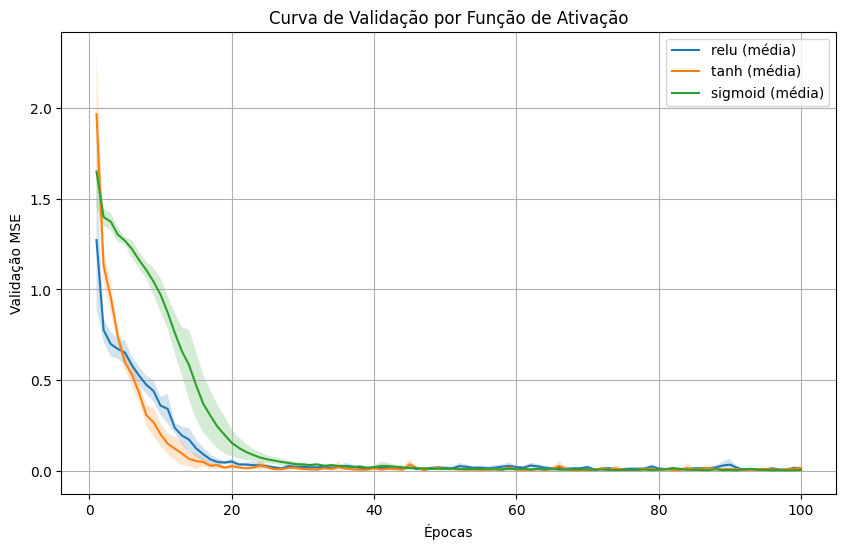

In [30]:
# Agrupar os históricos por ativação
activation_histories = {"relu": [], "tanh": [], "sigmoid": []}

for r in results:
    activation_histories[r["activation_function"]].append(r["history"]["val_loss"])

plt.figure(figsize=(10, 6))

for act, histories in activation_histories.items():
    # converte lista de listas para numpy array (execuções x épocas)
    histories = np.array(histories)
    mean_curve = histories.mean(axis=0)
    std_curve = histories.std(axis=0)
    epochs = range(1, len(mean_curve) + 1)

    # plota média
    plt.plot(epochs, mean_curve, label=f"{act} (média)")
    # área sombreada ± desvio padrão
    plt.fill_between(epochs, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)

plt.xlabel("Épocas")
plt.ylabel("Validação MSE")
plt.title("Curva de Validação por Função de Ativação")
plt.legend()
plt.grid(True)
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


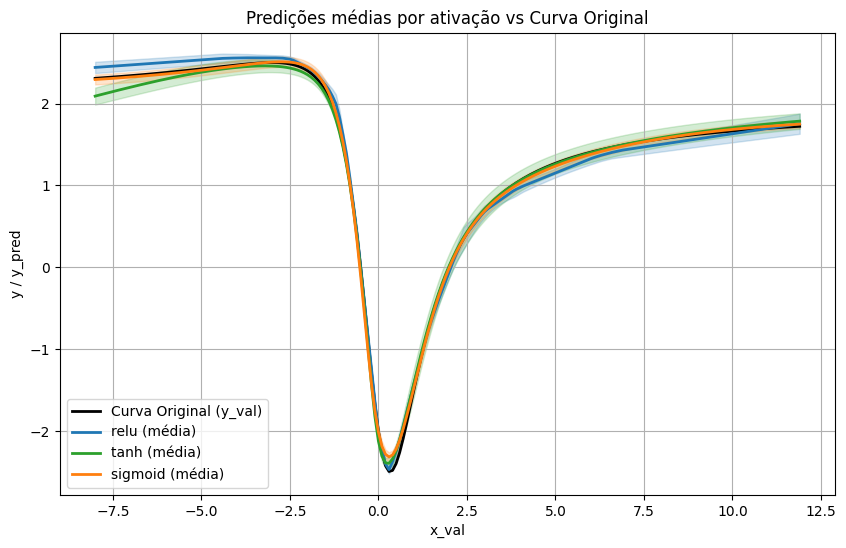

In [32]:
plt.figure(figsize=(10, 6))

# curva original
plt.plot(x_val, y_val, "k-", linewidth=2, label="Curva Original (y_val)")

# cores diferentes para cada função de ativação
colors = {"relu": "tab:blue", "tanh": "tab:green", "sigmoid": "tab:orange"}

for act in ["relu", "tanh", "sigmoid"]:
    # pega todos os modelos dessa ativação
    act_models = [r["trained_model"] for r in results if r["activation_function"] == act]
    
    # calcula as predições de todas execuções
    preds = np.array([model.predict(x_val).flatten() for model in act_models])
    
    # média e desvio padrão ponto a ponto
    mean_pred = preds.mean(axis=0)
    std_pred = preds.std(axis=0)
    
    # plota curva média
    plt.plot(x_val, mean_pred, color=colors[act], linewidth=2, label=f"{act} (média)")
    # plota área sombreada (média ± std)
    plt.fill_between(x_val, mean_pred - std_pred, mean_pred + std_pred,
                     color=colors[act], alpha=0.2)

plt.xlabel("x_val")
plt.ylabel("y / y_pred")
plt.title("Predições médias por ativação vs Curva Original")
plt.legend()
plt.grid(True)
plt.show()